### Imports

In [446]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

#imports for modelling
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import random
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

random_state = 42
np.random.seed(42)

## Data preprocessing

In [447]:
df_train = pd.read_csv('Data/df_train_preprocessed.csv')
df_train.head()

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,glucose_test_performed,a1c_test_performed,rosiglitazone,pioglitazone,glipizide,metformin,repaglinide,glyburide,insulin,glimepiride
0,533253,70110,Caucasian,1,75,NaN,No provider,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,426224,29775006,AfricanAmerican,0,55,NaN,No provider,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,634063,80729253,Caucasian,1,65,NaN,No provider,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,890610,2919042,AfricanAmerican,0,65,NaN,MC,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,654194,84871971,Caucasian,1,75,NaN,HM,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [448]:
df_train['readmitted_multiclass'].value_counts()

No          38405
>30 days    24881
<30 days     7950
Name: readmitted_multiclass, dtype: int64

In [449]:
#ordinal encoding for multiclass variable
ordinal_mapping = {'No': 0, '>30 days': 1, '<30 days': 2}
df_train['readmitted_multiclass'] = df_train['readmitted_multiclass'].map(ordinal_mapping)

#### Payer code

In [450]:
#Let's consider only most popular providers (>3% of dataset) and group all others to another group 'Other provider'
cnt = df_train[['payer_code', 'encounter_id']].groupby(by = 'payer_code').count().sort_values(by='encounter_id', ascending = False)
share = cnt/df_train['payer_code'].count()
big_share = share > 0.1
big_share_providers = list(big_share[big_share['encounter_id'] == True].index)
df_train['payer_code'] = df_train['payer_code'].apply(lambda x: x if x in big_share_providers else 'Other provider')

#one hot encoding for this variable since it has no order
#use drop='first' to avoid multicollinearity
encoder_payer_code = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_payer_code.fit_transform(df_train['payer_code'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, 
                                             columns=encoder_payer_code.get_feature_names_out(['payer_code']))], axis=1)


#### Admission_type

In [451]:
df_train['admission_type'].isna

<bound method Series.isna of 0        Emergency
1        Emergency
2              NaN
3        Emergency
4         Elective
           ...    
71231     Elective
71232       Urgent
71233          NaN
71234    Emergency
71235       Urgent
Name: admission_type, Length: 71236, dtype: object>

In [452]:
pd.crosstab(df_train['admission_type'], df_train['readmitted_multiclass'])
#newborn and trauma center barely have any values, so we are not keeping them

readmitted_multiclass,0,1,2
admission_type,,,
Elective,7801,4038,1372
Emergency,19874,13530,4338
Newborn,4,2,0
Trauma Center,13,0,0
Urgent,7065,4499,1460


In [453]:
pd.crosstab(df_train['admission_type'], df_train['readmitted_multiclass'])

readmitted_multiclass,0,1,2
admission_type,,,
Elective,7801,4038,1372
Emergency,19874,13530,4338
Newborn,4,2,0
Trauma Center,13,0,0
Urgent,7065,4499,1460


In [454]:
df_train['admission_type'] = df_train['admission_type'].str.lower()
irrelevant_admission_types = ['Newborn', 'Trauma Center']

irrelevant_admission_types = [value.lower() for value in irrelevant_admission_types]

df_train['admission_type'] = df_train['admission_type'].apply(lambda x: 'Other Admission Type' if x in irrelevant_admission_types else x)

#one hot encode for admission type
encoder_admission_type = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_admission_type.fit_transform(df_train['admission_type'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, 
                                             columns=encoder_admission_type.get_feature_names_out(['admission_type']))], axis=1)

In [455]:
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan', 'payer_code_HM', 'payer_code_MC',
       'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
       'payer_code_SP', 'total_visits', 'max_visits_of_

#### Medical_specialty

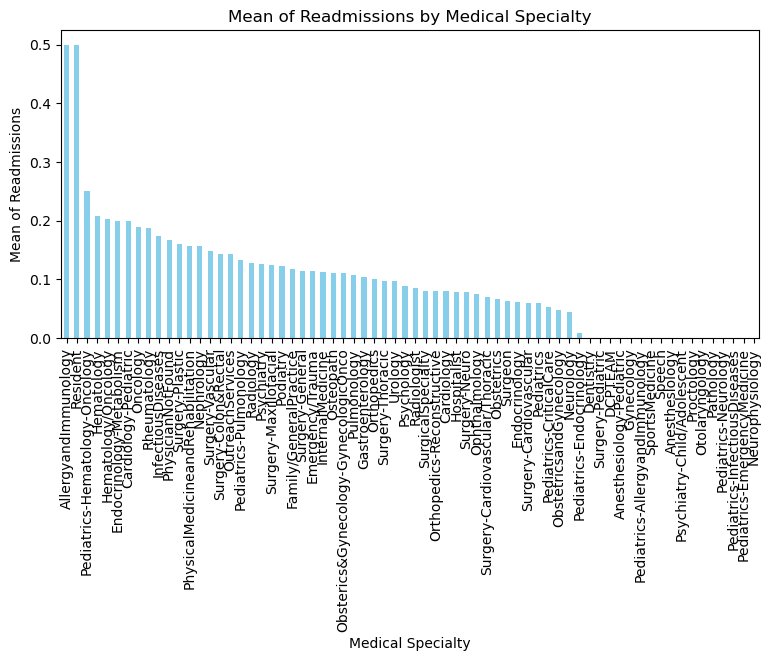

In [456]:
grouped_data = df_train.groupby('medical_specialty')['readmitted_binary'].mean()

import matplotlib.pyplot as plt

# Sort specialties based on mean values
sorted_data = grouped_data.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(9, 4))
sorted_data.plot(kind='bar', color='skyblue')
plt.title('Mean of Readmissions by Medical Specialty')
plt.ylabel('Mean of Readmissions')
plt.xlabel('Medical Specialty')
plt.show()

In [457]:
#we will create  new variable reflecting this
df_train['no_medical_specialty'] = df_train['medical_specialty'].apply(lambda x: 1 if pd.isna(x) else 0) 

#### Discharge_disposition

In [458]:

cnt = df_train[['encounter_id','discharge_disposition']].fillna('Not known').groupby(by = 'discharge_disposition').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','discharge_disposition']].fillna('Not known').groupby(by = 'discharge_disposition').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)

,encounter_id,readmitted_binary
discharge_disposition,,
Admitted as an inpatient to this hospital,13,0.538462
Still patient or expected to return for outpatient services,2,0.500000
Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital,98,0.397959
Discharged/transferred within this institution to Medicare approved swing bed,44,0.386364
Discharged/transferred to another rehab fac including rehab units of a hospital .,1393,0.278536
Discharged/transferred to another type of inpatient care institution,822,0.209246
Discharged/transferred to another short term hospital,1488,0.165323
Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,32,0.156250
Left AMA,421,0.147268


### Diagnosis variables 

#### Diabetes diagnoses

From what i found we can try to sort diabetes types by severity and make some order to create new variable

To make it more simple let's consider only 4 digits of code for this task. Here are the diagnoses according to what i found:

1. Non-specific code 250 Diabetes mellitus
2. Non-specific code 250.0 Diabetes mellitus without mention of complication
3. Non-specific code 250.9 Diabetes with unspecified complication
4. Non-specific code 250.8 Diabetes with other specified manifestations
5. Non-specific code 250.7 Diabetes with peripheral circulatory disorders
6. Non-specific code 250.6 Diabetes with neurological manifestations
7. Non-specific code 250.5 Diabetes with ophthalmic manifestations
8. Non-specific code 250.4 Diabetes with renal manifestations
9. Non-specific code 250.3 Diabetes with other coma
10. Non-specific code 250.2 Diabetes with hyperosmolarity
11. Non-specific code 250.1 Diabetes with ketoacidosis

And one more variable with types of diabetes (1/2, controlled/uncontrolled, dont know):

- ***.*0 type II or unspecified type, not stated as uncontrolled - in our case i guess it will be just ***.*
- ***.*1 type I [juvenile type], not stated as uncontrolled 
- ***.*2 type II or unspecified type, uncontrolled 
- ***.*3 type I [juvenile type], uncontrolled

In [459]:
d = pd.concat([df_train['primary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_train['secondary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_train['additional_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan)], axis = 1)
d.fillna('q', inplace = True)
df_train['diabetes_diagnosis'] = (d['secondary_diagnosis']+d['primary_diagnosis']+d['additional_diagnosis']).apply(lambda x: x.replace('q', ''))

In [460]:
df_train['diabetes_diagnosis_4_digits'] = df_train['diabetes_diagnosis'].astype(str).apply(lambda x: x[:5].replace('25025', '250'))

df_train['diabetes_type'] = df_train['diabetes_diagnosis'].apply(lambda x: 'I - uncontrolled' 
                                     if re.match(r'\d{3}\.\d{1}3', x)        
                                     else ( 'II - uncontrolled'
                                           if re.match(r'\d{3}\.\d{1}2', x)
                                     else ( 'I - controlled'
                                           if re.match(r'\d{3}\.\d{1}1', x)
                                     else ( 'II - controlled'
                                           if re.match(r'\d{3}\.', x)
                                     else np.nan))))


In [461]:
i = 'diabetes_type'
cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean()
pd.concat([cnt, mean], axis = 1).sort_values(by = i, ascending=False)

,encounter_id,readmitted_binary
diabetes_type,,
II - uncontrolled,4639,0.123734
II - controlled,5132,0.146532
I - uncontrolled,1329,0.133183
I - controlled,2910,0.139863


In [462]:
i = 'diabetes_diagnosis_4_digits'
cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean()
pd.concat([cnt, mean], axis = 1).sort_values(by = i, ascending=False)

,encounter_id,readmitted_binary
diabetes_diagnosis_4_digits,,
250.9,341,0.117302
250.8,2333,0.135448
250.7,752,0.196809
250.6,2019,0.174344
250.5,308,0.159091
250.4,1208,0.156457
250.3,56,0.125000
250.2,255,0.058824
250.1,1756,0.124146


We will use these as 3 main groups

Group 1: Mild (No Mention of Complications)
- 250.0 Diabetes mellitus without mention of complications
- 250

Group 2: Moderate (Complications Present, but Not Severe)
- 250.8 Diabetes with other specified manifestations
- 250.7 Diabetes with peripheral circulatory disorders
- 250.6 Diabetes with neurological manifestations
- 250.5 Diabetes with ophthalmic manifestations
- 250.4 Diabetes with renal manifestations

Group 3: Severe (Complications with Significant Impact)
- 250.9 Diabetes with unspecified complication
- 250.3 Diabetes with other coma
- 250.2 Diabetes with hyperosmolarity
- 250.1 Diabetes with ketoacidosis



In [463]:
def categorize_severity(code):
    if code in ['250.0', '250']:
        return 'Mild'
    elif code in ['250.8', '250.7', '250.6', '250.5', '250.4']:
        return 'Moderate'
    elif code in ['250.9', '250.3', '250.2', '250.1']:
        return 'Severe'
    else:
        return 'No diabetes'

df_train['diabetes_severity_group'] = df_train['diabetes_diagnosis_4_digits'].apply(categorize_severity)


In [464]:
i = 'diabetes_severity_group'
cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean()
pd.concat([cnt, mean], axis = 1).sort_values(by = i, ascending=False)

,encounter_id,readmitted_binary
diabetes_severity_group,,
Severe,2408,0.116279
No diabetes,44731,0.112115
Moderate,6620,0.159215
Mild,17477,0.091606


In [465]:
#one hot encoding for this variable since it has no order
encoder_diabetes_severity = OneHotEncoder(sparse_output = False)
one_hot_encoded = encoder_diabetes_severity.fit_transform(df_train['diabetes_severity_group'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_severity.get_feature_names_out(['diabetes_severity_group']))], axis=1)
df_train.drop(columns = 'diabetes_severity_group_No diabetes', inplace = True)


In [466]:
#one hot encoding for this variable since it has no order
encoder_diabetes_type = OneHotEncoder(sparse_output = False)
one_hot_encoded = encoder_diabetes_type.fit_transform(df_train['diabetes_type'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_type.get_feature_names_out(['diabetes_type']))], axis=1)
df_train.drop(columns = 'diabetes_type_nan', inplace = True)
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       ...
       'admission_type_emergency', 'admission_type_urgent',
       'admission_type_nan', 'diabetes_severity_group_Mild',
       'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
       'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
       'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled'],
      dtype='object', length=107)

- primary_diagnosis - Primary diagnosis (coded as first three digits of ICD9)
- secondary_diagnosis - Secondary diagnosis (first three digits of ICD9)
- additional_diagnosis - Additional secondary diagnosis (first three digits of ICD9)

### Test results and medications variables

#### Glucose_test_result

We have weird correlation between glucose test performance and unavailable Admission type

In [467]:
#for people who didn't perform test we will just put 0 since ther are a lot of such people
df_train['glucose_test_result'] = df_train['glucose_test_result'].replace({'Norm': 100,
                                           '>200': 200,
                                           '>300': 300,
                                            np.nan: 0})

df_train.groupby('glucose_test_result')['readmitted_binary'].value_counts(normalize = True).unstack()

readmitted_binary,0,1
glucose_test_result,,
0,0.889353,0.110647
100,0.878184,0.121816
200,0.869194,0.130806
300,0.857316,0.142684


#### A1c_test_result 

In [468]:
# Create a binary variable which is 0 if the glucose test was not performed and 1 if it was
df_train['a1c_test_performed'] = df_train['a1c_test_result'].apply(lambda x: 0 if pd.isna(x) else 1)

df_train.groupby('a1c_test_performed')['readmitted_binary'].value_counts(normalize = True).unstack()

readmitted_binary,0,1
a1c_test_performed,,
1,0.888399,0.111601


In [469]:
# We will apply same manipulations as for glucose test

df_train['a1c_test_result'] = df_train['a1c_test_result'].replace({'Norm': 6,
                                           '>7': 7,
                                           '>8': 8,
                                            np.nan: 0})


df_train.groupby('a1c_test_result')['readmitted_binary'].value_counts(normalize = True).unstack()

readmitted_binary,0,1
a1c_test_result,,
0,0.885772,0.114228
6,0.900086,0.099914
7,0.898449,0.101551
8,0.903769,0.096231


#### Change_in_meds_during_hospitalization

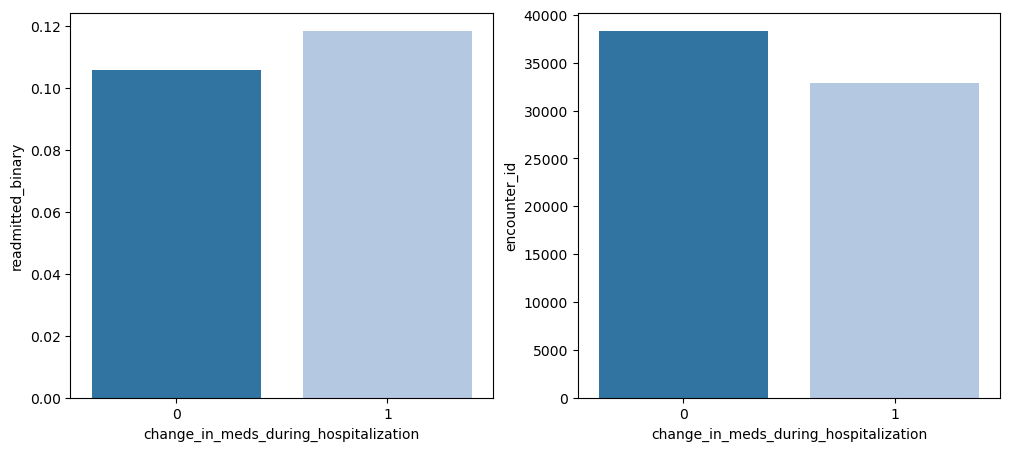

In [470]:
df_train['change_in_meds_during_hospitalization'] = df_train['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0}).astype(int)

i = 'change_in_meds_during_hospitalization'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)
counts = df_train.groupby(i)['encounter_id'].count().reset_index().sort_values(by = i)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=i, y='readmitted_binary', data=averages, ax=axes[0])
sns.barplot(x=i, y='encounter_id', data=counts, ax=axes[1])
plt.show()

#### Prescribed_diabetes_meds

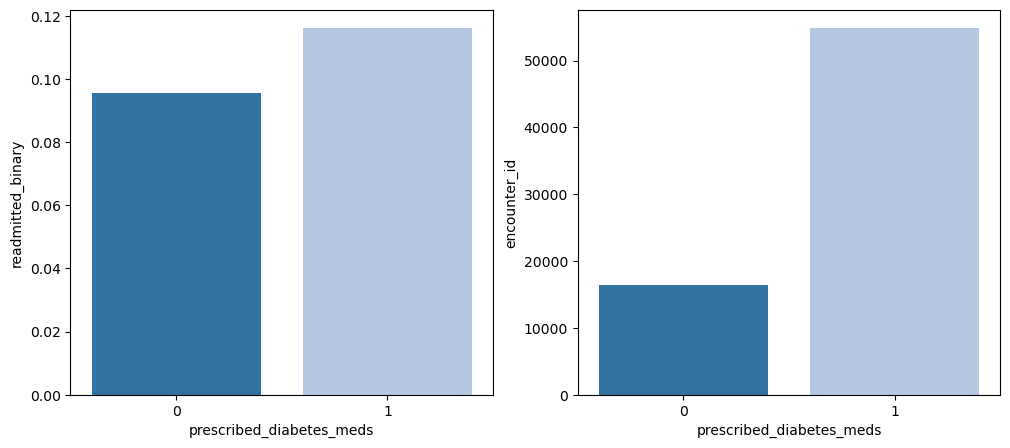

In [471]:
df_train['prescribed_diabetes_meds'] = df_train['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0}).astype(int)

i = 'prescribed_diabetes_meds'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)
counts = df_train.groupby(i)['encounter_id'].count().reset_index().sort_values(by = i)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=i, y='readmitted_binary', data=averages, ax=axes[0])
sns.barplot(x=i, y='encounter_id', data=counts, ax=axes[1])
plt.show()

#### Medication

In [472]:
#binary identifier if there was medication or not
df_train['medication_binary'] = df_train['medication'].apply(lambda x: 0 if x == '[]' else (1 if len(str(x)) > 2 else np.nan))

In [473]:
cnt = df_train[['encounter_id','medication_binary']].groupby(by = 'medication_binary').count().sort_values(by = 'encounter_id', ascending=False).head(50)
mean = df_train[['readmitted_binary','medication_binary']].groupby(by = 'medication_binary').mean().sort_values(by = 'readmitted_binary', ascending=False).head(50)
pd.concat([cnt, mean], axis = 1)

,encounter_id,readmitted_binary
medication_binary,,
1,54890,0.116305
0,16346,0.095803


In [474]:
medication_list = []
for i in df_train['medication']:
    i = i.replace('[', '').replace(']', '').replace("'", '').replace('-', ',')
    x = i.strip().split(',')
    for j in x:
        if len(j) > 0:
            medication_list.append(j.strip())
medication_list = list(set(medication_list))
medication_list

['insulin',
 'glipizide',
 'chlorpropamide',
 'acarbose',
 'glimepiride',
 'metformin',
 'rosiglitazone',
 'miglitol',
 'tolbutamide',
 'acetohexamide',
 'repaglinide',
 'pioglitazone',
 'glyburide',
 'tolazamide',
 'troglitazone',
 'nateglinide']

In [475]:
for i in medication_list:
    df_train[i] = df_train['medication'].astype(str).apply(lambda x: 1 if i in x else 0)
#get rid of rare medications columns
for i in medication_list:
    if df_train[i].sum()/len(df_train) < 0.01:
        df_train.drop(columns = [i], inplace = True)

for i in medication_list:
    try:
        cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
        mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
        print(pd.concat([cnt, mean], axis = 1))
    except:
        pass

         encounter_id  readmitted_binary
insulin                                 
1               38105           0.121952
0               33131           0.099695
           encounter_id  readmitted_binary
glipizide                                 
0                 62321           0.111616
1                  8915           0.111497
             encounter_id  readmitted_binary
glimepiride                                 
0                   67661           0.112310
1                    3575           0.098182
           encounter_id  readmitted_binary
metformin                                 
0                 56805           0.115676
1                 14431           0.095558
               encounter_id  readmitted_binary
rosiglitazone                                 
0                     66762           0.112025
1                      4474           0.105275
             encounter_id  readmitted_binary
repaglinide                                 
0                   70158         

### Imputation of missing values

In [476]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

features_for_transform = [
    'gender', 
    'has_weight',
    'race_Asian', 'race_Caucasian', 'race_Hispanic',
    'race_Other', 'race_nan',
    
    'age', 
    'average_pulse_bpm',
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'total_visits',
    'max_visits_of_one_type',
    'length_of_stay_in_hospital',
    'number_lab_tests', 
    'non_lab_procedures', 
    'number_of_medications',
    'number_diagnoses'
]

df_train_for_transform = df_train[features_for_transform]

features_for_scaling = ['age',
                        'average_pulse_bpm',
                        'outpatient_visits_in_previous_year',
                        'emergency_visits_in_previous_year',
                        'inpatient_visits_in_previous_year',
                        'total_visits',
                        'max_visits_of_one_type',
                        'length_of_stay_in_hospital',
                        'number_lab_tests', 
                        'non_lab_procedures', 
                        'number_of_medications',
                        'number_diagnoses']

scaler = MinMaxScaler()
scaled_df_train_for_transform = scaler.fit_transform(df_train_for_transform[features_for_scaling])
scaled_df_train_for_transform = np.concatenate((df_train_for_transform[df_train_for_transform.columns.difference(features_for_scaling)],
                np.array(scaled_df_train_for_transform)), axis=1)


imputer = KNNImputer(n_neighbors=5)
imputed_data_train = pd.DataFrame(imputer.fit_transform(scaled_df_train_for_transform), columns = features_for_transform)

imputed_data_train = pd.DataFrame(np.concatenate((imputed_data_train[imputed_data_train.columns.difference(features_for_scaling)],
                scaler.inverse_transform(imputed_data_train[features_for_scaling])), axis = 1), columns = features_for_transform)



features_to_impute = ['age', 'gender', 'number_lab_tests', 'number_of_medications']
df_train[features_to_impute] = np.round(imputed_data_train[features_to_impute])

df_train

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,admission_type_urgent,admission_type_nan,diabetes_severity_group_Mild,diabetes_severity_group_Moderate,diabetes_severity_group_Severe,diabetes_type_I - controlled,diabetes_type_I - uncontrolled,diabetes_type_II - controlled,diabetes_type_II - uncontrolled,medication_binary
0,533253,70110,Caucasian,1.0,75.0,NaN,No provider,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,426224,29775006,AfricanAmerican,0.0,55.0,NaN,No provider,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,634063,80729253,Caucasian,1.0,65.0,NaN,No provider,0,0,1,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,890610,2919042,AfricanAmerican,0.0,65.0,NaN,MC,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,654194,84871971,Caucasian,1.0,75.0,NaN,Other provider,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71231,660160,24531381,AfricanAmerican,1.0,85.0,NaN,MC,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
71232,826429,4663818,AfricanAmerican,1.0,75.0,NaN,No provider,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
71233,332030,23397147,Caucasian,1.0,65.0,NaN,No provider,0,2,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
71234,757560,52161750,Caucasian,0.0,65.0,NaN,Other provider,0,0,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


## Model and feature selection

### Imports for modelling

In [477]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import random

random_state=42
np.random.seed(42)

### Set train and test data

In [482]:
columns_to_use = ['encounter_id', 'patient_id', 
                  
                  'gender', 'age', 'has_weight',
                  
                  'outpatient_visits_in_previous_year',
                  'emergency_visits_in_previous_year',
                  'inpatient_visits_in_previous_year', 
                  'total_visits', 'max_visits_of_one_type',

                  
                  
                  'average_pulse_bpm', 
                  'length_of_stay_in_hospital', 
                  
                  'number_lab_tests',
                  'non_lab_procedures', 
                  'number_of_medications', 
                  'number_diagnoses',
                  
                  'glucose_test_result', 'glucose_test_performed', 
                  'a1c_test_result','a1c_test_performed',
                  
                  'change_in_meds_during_hospitalization', 
                  'prescribed_diabetes_meds', 

                  'high_admission_source',
                  'medium_admission_source', 'low_admission_source',

                  'admission_type_elective',
                  'admission_type_emergency', 'admission_type_urgent',
                 'admission_type_nan',

                  'race_Asian', 'race_Caucasian', 'race_Hispanic',
                  'race_Other', 'race_nan', 
                  
                  'payer_code_No provider',
                  'payer_code_Other provider',
                
                  
                  'discharged_home_hospice', 'expired', 'high_discharge_disposition',
                  'medium_discharge_disposition', 
                   
                  'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
                  'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
                  'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
                  'medication_binary',
                  'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
                  'rosiglitazone', 'glipizide', 'insulin', 'readmitted_binary']
                 

In [483]:
data = df_train[columns_to_use]
target = df_train['readmitted_multiclass']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### Imports for modelling

In [484]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import random
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

random_state = 42
np.random.seed(42)

In [485]:
def target_encoder(fit_data, transform_data, target, features_for_encoding, smoothing=100):
    target_encoder = ce.TargetEncoder(cols=features_for_encoding, smoothing=smoothing)  
    target_encoder.fit(fit_data[features_for_encoding], fit_data[target].astype(int))
    encoded_df = target_encoder.transform(transform_data[features_for_encoding])
    features_for_encoding_pass = [i + '_target' for i in features_for_encoding]
    encoded_df =  pd.concat((transform_data[transform_data.columns.difference(features_for_encoding)],
                        pd.DataFrame(np.array(encoded_df), columns = features_for_encoding_pass)), axis=1)
    return encoded_df, features_for_encoding_pass

In [486]:
def scaler(fit_data, transform_data, features_for_scaling, scaling_type = 'minmax'):
    if scaling_type == 'minmax':
        sc = MinMaxScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1) 
        return scaled_df
    if scaling_type == 'standard':
        sc = StandardScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1)
        return scaled_df

In [487]:
def patient_features(df_train, df_test, multiclass = False):
    df_all = pd.concat([df_train, df_test])

    list_for_scaling = []
    
    # total visits of one patient in dataset, excluding current visit
    patient_total_visits = df_train[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_train = pd.merge(df_train, patient_total_visits, how = 'left', on = 'patient_id').fillna(0)

    patient_total_visits = df_all[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_test = pd.merge(df_test, patient_total_visits, how = 'left', on = 'patient_id').fillna(0)

    list_for_scaling.append('patient_total_visits')

    if multiclass == False:
        # check if we know that this person was readmitted on any other visit we know and calculate number of readmissions
        was_readmitted_encounter = df_train[['patient_id', 
                                   'encounter_id',
                                   'readmitted_binary']].groupby(['patient_id','encounter_id']).max(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_encounter'}).reset_index()
        was_readmitted_patient = df_train[['patient_id', 
                                       'readmitted_binary']].groupby(['patient_id']).sum(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_patient'}).reset_index()
        was_readmitted = pd.merge(was_readmitted_encounter, was_readmitted_patient, on = 'patient_id')
        was_readmitted['patient_num_readmitted'] = (was_readmitted['was_readmitted_patient'] - was_readmitted['was_readmitted_encounter']).astype('int')
        was_readmitted['patient_was_readmitted'] = was_readmitted['patient_num_readmitted'].apply(lambda x: 1 if x > 0 else 0).astype('category')
        df_train = pd.merge(df_train, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id').fillna(0)
    
        df_test = pd.merge(df_test, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id').fillna(0)
        df_test[['patient_num_readmitted', 'patient_was_readmitted']] = df_test[['patient_num_readmitted', 'patient_was_readmitted']].astype(int)
        list_for_scaling.append('patient_num_readmitted')

    return df_train, df_test, list_for_scaling

In [488]:
def upsampler(data, 
              target,  
              upsample_type = 'simple', 
              upsample_size = 1):
    majority_class_label = data[target].value_counts().idxmax()
    minority_class_labels = data[target].value_counts().index.drop(majority_class_label)
    balanced_data = pd.DataFrame()
    if upsample_type == 'simple':
        for label in minority_class_labels:
            if len(data[data[target] == majority_class_label])*upsample_size > len(data[data[target] == label]):
                minority_upsampled = resample(data[data[target] == label], replace=True, n_samples=int(len(data[data[target] == majority_class_label])*upsample_size), 
                                                  random_state = random_state)
                balanced_data = pd.concat([balanced_data, minority_upsampled])
            else:
                balanced_data = pd.concat([balanced_data, data[data[target] == label]])
        balanced_data = pd.concat([balanced_data, data[data[target] == majority_class_label]])
    if upsample_type == 'SMOTE':
        X = data.drop(columns = target)
        categorical_features = X.select_dtypes(include='category').columns
        cat_ind = [X.columns.get_loc(col) for col in categorical_features]
        smote_nc = SMOTENC(categorical_features=cat_ind, random_state=random_state)
        X_resampled, y_resampled = smote_nc.fit_resample(X, data[target])  
        balanced_data = pd.concat([X_resampled, y_resampled], axis = 1)
    return balanced_data

In [489]:
def cross_validation(data, 
                     target, 
                     model, 
                     params, 
                     multiclass = False,
                     
                     scaling = False,
                     features_for_scaling_minmax = [],
                     features_for_scaling_standard = [],

                     target_encoding = False,
                     features_for_encoding = [],
                     smoothing = 100,
                     
                     upsample = False, 
                     upsample_size = 1,
                     upsample_type = 'simple', 
                     cv=5
                     ):
    # Defining some lists to collect data
    feature_imp = []
    f1 = []
    confusion_matrix_list = []
    precision_score_list = []
    recall_score_list = []
    roc_auc_score_list = []

    # A bit of resampling just to mix data
    data = data.sample(frac=1, random_state=random_state)
    data[target] = data[target].astype(int)

    # create stratified folds
    skf = StratifiedKFold(n_splits=cv, shuffle = True, random_state = random_state)
    split = list(skf.split(data.drop(columns = target), data[target]))
    all_train_index = [i[0] for i in split]
    all_val_index = [i[1] for i in split]
    
    for i in range(cv):
        val_index = all_val_index[i]
        train_index = all_train_index[i]
        train_data, val_data = data.loc[train_index], data.loc[val_index]


        #Target encoding
        if target_encoding == True:
                val_data, _ = target_encoder(train_data, val_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                train_data, features_for_encoding_pass = target_encoder(train_data, train_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                features_for_scaling_minmax_full = features_for_scaling_minmax + list(features_for_encoding_pass)
        else:
            features_for_scaling_minmax_full = features_for_scaling_minmax

        #creating features on patient level that we will use
        train_data, val_data, pat_features_scale = patient_features(train_data, val_data, multiclass = multiclass)
        features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale

            
        # Scaling features
        if scaling == True:
            if len(features_for_scaling_minmax) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            if len(features_for_scaling_standard) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_standard, scaling_type = 'standard')
                train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
                
        # Upsampling only train data 
        if upsample == True:
            train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)

        # Defining train and val datasets
        X_train = train_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_train = train_data[target]
        
        X_val = val_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_val = val_data[target]

        # Fit and predict
        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        #Feature importances if our model can do this
        try:
            try:
                feature_imp.append(model.feature_importances_)
            except:
                pass
            try:
                feature_imp.append(model.coef_)
            except:
                pass
        except:
            pass

        # Calculating f1 scores and other metrics
        if multiclass == False:
            f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
            recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
            precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
            roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
        if multiclass == True:
            f1.append([f1_score( y_train, y_pred_train, average = 'micro'), f1_score(y_val, y_pred_val, average = 'micro')])
            recall_score_list.append([recall_score( y_train, y_pred_train, average = 'micro'), recall_score(y_val, y_pred_val, average = 'micro')])
            precision_score_list.append([precision_score(y_train, y_pred_train, average = 'micro'), precision_score(y_val, y_pred_val, average = 'micro')])
            # roc_auc_score_list.append([roc_auc_score( y_train, y_pred_train.reshape(-1, 1), multi_class='ovr', average = 'micro'), roc_auc_score(y_val, y_pred_val.reshape(-1, 1), multi_class='ovr', average = 'micro')])

        
        confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])

    # Printing results
    print(model)
    print('F1 train: {:.3f}, F1_val: {:.3f}'.format(np.array(f1).mean(axis = 0)[0],
                                                   np.array(f1).mean(axis = 0)[1]))
    return [model.get_params(), 
            {'f1' : np.array(f1).mean(axis = 0), 
             'recall_score' : np.array(recall_score_list).mean(axis = 0),
             'precision_score' : np.array(precision_score_list).mean(axis = 0),
             'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
            }, 
            {'f1' : f1, 
             'recall_score' : recall_score_list,
             'precision_score' : precision_score_list,
             'roc_auc_score' : roc_auc_score_list,
             'confusion_matrix': confusion_matrix_list
            },
            X_train.columns, 
            np.mean(np.array(feature_imp), axis = 0),
            ]

### Important functions

### Model selection

In [490]:
features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result']
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

data = pd.concat([X_train, y_train], axis = 1)

target = 'readmitted_multiclass'

**Random Forest**

In [491]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=110, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)

# Calculate the F1 score
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')


feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances)
print(f1_rf)


readmitted_binary                 0.239089
patient_id                        0.077239
encounter_id                      0.070229
average_pulse_bpm                 0.061033
number_lab_tests                  0.060530
                                    ...   
diabetes_type_I - uncontrolled    0.001239
high_admission_source             0.001033
race_Asian                        0.000774
medium_discharge_disposition      0.000000
a1c_test_performed                0.000000
Length: 66, dtype: float64
0.6801807427783456


**Logistic Regression**

In [492]:
lr_classifier = LogisticRegression(max_iter=900)
lr_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr_classifier.predict(X_test)

# Calculate accuracy as an example metric
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f1_lr)

0.3786433311008068


**MLP CLassifier**

In [493]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create and train a Multi-layer Perceptron (MLP) classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_mlp = mlp_classifier.predict(X_test)

f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

print(f1_mlp)


0.39782163706081397


**Decision Trees**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)

f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print(f1_dt)